In [6]:
import torch
import numpy as np
from scipy.stats import norm

np.random.seed(0)


loc1, scale1 = -1.0, 0.2
loc2, scale2 = 1.0, 0.3
weights = [0.4, 0.6]

def mixture_pdf(x):
    return weights[0]*norm.pdf(x, loc1, scale1) + weights[1]*norm.pdf(x, loc2, scale2)


normal_mean = torch.tensor([0.0], requires_grad=True)
normal_var = torch.tensor([1.0], requires_grad=True)


optimizer = torch.optim.SGD([normal_mean, normal_var], lr=0.1)


loss_fn = torch.nn.KLDivLoss(reduction='batchmean')


num_iterations = 1000
x = np.linspace(-5, 5, 1000)
mean_list = []
var_list = []
kld_list = []
for i in range(num_iterations):
    optimizer.zero_grad()
    

    normal = torch.distributions.Normal(normal_mean, normal_var.sqrt())
    kl_div = loss_fn(torch.tensor(mixture_pdf(x), dtype=torch.float32), normal.log_prob(torch.tensor(x, dtype=torch.float32)).exp())
    
    kl_div.backward()
    optimizer.step()
    mean_list.append(torch.distributions.Normal(normal_mean, normal_var.sqrt()).mean.item())
    var_list.append(torch.distributions.Normal(normal_mean, normal_var.sqrt()).variance.item())
    kld_list.append(kl_div.item())


final_normal = torch.distributions.Normal(normal_mean, normal_var.sqrt())
print(f"Final Normal distribution: Mean={final_normal.mean.item()}, Variance={final_normal.variance.item()}")


Final Normal distribution: Mean=0.11598855257034302, Variance=3.002490520477295


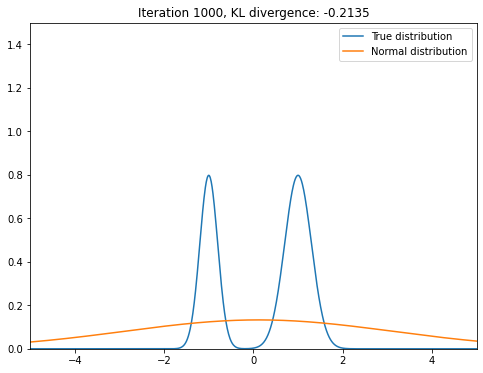

In [7]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(-5, 5)
ax.set_ylim(0, 1.5)


x = np.linspace(-5, 5, 1000)
true_pdf = mixture_pdf(x)
line_true, = ax.plot(x, true_pdf, label='True distribution')


line_normal, = ax.plot([], [], label='Normal distribution')


ax.legend()


def update(i):

    mean = mean_list[i]
    std = var_list[i]
    

    normal = torch.distributions.Normal(mean, std)
    normal_pdf = normal.log_prob(torch.tensor(x, dtype=torch.float32)).exp().detach().numpy()
    

    line_normal.set_data(x, normal_pdf)
    

    ax.set_title(f"Iteration {i+1}, KL divergence: {kld_list[i]:.4f}")
    
    return line_normal,


anim = FuncAnimation(fig, update, frames=num_iterations, blit=True)
anim.save('normal_fit_reverse_kl.gif', writer='imagemagick')

plt.show()
